In [64]:
import numpy as np

# generate data

In [65]:
# In real world, you cannot learn how the data was generated. So do not rely on this function when coding your lab.

# In order to make the DEBUG more easy, I add the random seed for option 
def generate_data(dim = 10, num = 100, random_seed = -1):
    if random_seed != -1:
        np.random.seed(random_seed)
    x = np.random.normal(0, 10, [num, dim])

    if random_seed != -1:
        np.random.seed(random_seed)
    coef = np.random.uniform(-1, 1, [dim, 1])

    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)

    if random_seed != -1:
        np.random.seed(random_seed)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0

    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

In [66]:
# example
x, y, mr = generate_data(5, 100)
print(x[1:10, 1])
print(y[1:10])
print(mr)
print(type(x))




[ 10.57709908  -6.00867717  -4.05957033   2.86962942  -0.9660421
 -12.88587278   6.35784024 -16.63497723  18.11501855]
[[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]]
0.02
<class 'numpy.ndarray'>


# write your model class

In [67]:
# you can do anything necessary about the model
def my_max(a, b):
    return a if a > b else b

def find_zero(a, b):
    return 0 if a == 0 else b

def array_max(a:np.ndarray, b:np.ndarray)->np.ndarray:
    func_ = np.frompyfunc(my_max, 2, 1)
    return(func_(a, b))

def array_find0(a:np.ndarray, b:np.ndarray) -> np.ndarray:
    func_ = np.frompyfunc(find_zero, 2, 1)
    return(func_(a, b))

class SVM1:
    def __init__(self):
        """
        You can add some other parameters, which I think is not necessary
        """

    def fit(self, X:np.ndarray, y:np.ndarray, gamma = 0.25, lr = 0.002, tol=1e-4, max_times=100, silent = True):
        """
        ---
        parameters:
        ---
            X: Data characteristics
            y: Data category
            gamma: Loss function parameter. Default 0.001
            lr: Learning rate. Default 0.01
            max_times: The maximum times of training iterations. Default 100
            tol: 梯度下降的阈值 Defalut 1
        """
        m, n = X.shape
        self.w = np.zeros((n + 1, 1))

        temp_1 = np.ones((m, 1))
        X_hat:np.ndarray = np.c_[X, temp_1]

        temp_0 = np.zeros((m, 1))
        loss_list = []
        y_diag = np.diag(y.reshape(-1))

        if (silent):
            for times in range(max_times):
                xi = array_max(temp_0, 1 - (y_diag @ X_hat @ self.w))
                loss = 0.5 * (self.w.T @ self.w)[0][0] + gamma * (xi.sum())
                
                y_bar = array_find0(xi , y)

                delta_1 = self.w - gamma * (X_hat.T @ y_bar)
                
                if times >= 2 and abs(loss_list[-1] - loss) < tol:
                    loss_list.append(loss)
                    break

                self.w = self.w - lr * delta_1
                loss_list.append(loss)
        else:
            for times in range(max_times):
                xi = array_max(temp_0, 1 - (y_diag @ X_hat @ self.w))
                loss = 0.5 * (self.w.T @ self.w)[0][0] + gamma * (xi.sum())
                
                y_bar = array_find0(xi , y)

                delta_1 = self.w - gamma * (X_hat.T @ y_bar)
                
                if times >= 2 and abs(loss_list[-1] - loss) < tol:
                    loss_list.append(loss)
                    break

                if (times % 10 == 0):
                    print("Current times: {}, loss is {}".format(times, loss))

                self.w = self.w - lr * delta_1
                loss_list.append(loss)

        return loss_list, times
            

        
    def predict(self, X:np.ndarray):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """

        m, n = X.shape
        temp_1 = np.ones(m)
        X_hat:np.ndarray = np.c_[X, temp_1]

        temp = X_hat @ self.w
        ans = []
        for i in range(m):
            if temp[i] > 0:
                ans.append(1)
            else:
                ans.append(-1)
        
        return np.array(ans).reshape(-1, 1)

In [68]:
# you can do anything necessary about the model
from numpy import double


class SVM2:
    def __init__(self, X:np.ndarray, y:np.ndarray):
        """
        You can add some other parameters, which I think is not necessary
        """
        m, _ = X.shape
        self.X = X
        self.y = y
        
        self.alpha = np.zeros((m, 1))
        self.b = 0
        self.err = np.zeros((m, 1))
        self._update_e()

    
    def _x(self, X_index):
        return self.X[X_index, :]
    
    def _K(self, X1_index, X2_index = -1):
        if X2_index == -1:
            X2_index = X1_index
        return (self.X[X1_index, :] @ self.X[X2_index, :].T)

    def _y(self, y_index):
        return (self.y[y_index, :])[0]

    def _a(self, a_index):
        return (self.alpha[a_index, :])[0]

    def _e(self, e_index):
        return (self.err[e_index, :])[0]

    def _func(self, X_index):
        alpha_y = self.alpha * self.y
        return (alpha_y.T @ self.X @ self._x(X_index).T)[0] + self.b
        
    def _error(self, X_index):
        return self._func(X_index) - self._y(X_index)


    def _cut(self, a1_index, a2_index, a2_uncut, gamma) -> (float | bool):
        if self._y(a1_index) != self._y(a2_index):
            low = max(0, self._a(a2_index) - self._a(a1_index))
            high = min(gamma, gamma + self._a(a2_index) - self._a(a1_index))
        else:
            low = max(0, self._a(a2_index) + self._a(a1_index) - gamma)
            high = min(gamma, self._a(a2_index) + self._a(a1_index))

        if high == low:
            return False
        
        if a2_uncut > high:
            return high
        elif a2_uncut < low:
            return low
        return a2_uncut


    def _update_alpha(self, a1_index, a2_index, gamma):

        eta = self._K(a1_index) + self._K(a2_index) - 2 * self._K(a1_index, a2_index)

        if eta > 0:
            a2_uncut = self._a(a2_index) + self._y(a2_index) * (self._e(a1_index) - self._e(a2_index)) / eta
        else:
            # print("Eta <= 0")
            return False
        
        alpha2_new = self._cut(a1_index, a2_index, a2_uncut, gamma)
        if (alpha2_new == False):
            # print("Low == High")
            return False
        
        if (abs(self._a(a2_index) - alpha2_new) <1e-3):
            # print("Alpha2 moves too slow")
            return False

        alpha1_new = self._a(a1_index) + self._y(a1_index) * \
                                  self._y(a2_index) * (self._a(a2_index) - \
                                  alpha2_new)
        self._update_b(a1_index, a2_index, alpha1_new, alpha2_new, gamma)

        self.alpha[a1_index] = alpha1_new
        self.alpha[a2_index] = alpha2_new

        self._update_e()

        return True


    def _update_b(self, a1_index, a2_index, a1_new, a2_new, gamma):
        alpha_1 = self._a(a1_index) 
        alpha_2 = self._a(a2_index) 

        b1 = -self._e(a1_index) - \
                self._y(a1_index) * self._K(a1_index) * (a1_new - alpha_1) - \
                self._y(a2_index) * self._K(a2_index, a1_index) * (a2_new - alpha_2) + \
                self.b
        if 0 < alpha_1 < gamma:
            self.b = b1
            return
      
        b2 = -self._e(a2_index) - \
                self._y(a1_index) * self._K(a1_index, a2_index) * (a1_new - alpha_1) - \
                self._y(a2_index) * self._K(a2_index) * (a2_new - alpha_2) + \
                self.b
        if 0 < alpha_2 < gamma:
            self.b = b2
            return
        
        self.b = 0.5 * (b1 + b2)
        return

    def _update_e(self):
        m, _ = self.X.shape
        for i in range(m):
            self.err[i] = self._error(i) 







    def fit(self, gamma = 1, lr = 0.01, tol=1, max_times = 100, silent = True, epslion = 0):
        """
        Fit the coefficients via your methods
        """
        m, n = self.X.shape

        loss_list = []
        times = 0
        

        while times < max_times:
            alpha_y = self.alpha * self.y
            loss = self.alpha.sum() - 0.5 * (alpha_y.T @ self.X @ self.X.T @ alpha_y)[0][0]

            i_list = []
            i_dict = {}

            for i in range(m):
                if (self._a(i) < gamma and self._e(i) < -epslion) or \
                   (self._a(i) > 0 and self._e(i) > epslion):
                    val = abs(self._e(i) - epslion)
                    i_list.append(val)
                    i_dict[val] = i
                # temp = self._y(i) * self._func(i)
                # if self._a(i) <= 0 and temp < 1 - epslion:
                #     val = 1 - epslion - temp
                #     i_list.append(val)
                #     i_dict[val] = i

                # elif self._a(i) >= gamma and temp > 1 + epslion:
                #     val = 1 + epslion - temp
                #     i_list.append(val)
                #     i_dict[val] = i

                # elif abs(temp - 1) > epslion:
                #     val = abs(temp - 1) - epslion
                #     i_list.append(val)
                #     i_dict[val] = i

            if len(i_list) == 0:
                loss_list.append(loss)
                break

            i_list.sort()
            while len(i_list) > 0:
                a1 = i_dict[i_list.pop()]
                e1 = self._e(a1)

                err_dict = []
                err_list = []
                for i in self.err.tolist():
                    err_list.append(i[0])
                # print(err_list)
                for index, value in enumerate(err_list):
                    err_dict.append((value, index))
                err_dict.sort(key=takefirst)
                k = 0
    
                if e1 > 0:
                    while k < m:
                        a2 = err_dict[k][1]
                        if a1 != a2 and self._update_alpha(a1, a2, gamma):
                            break
                        k += 1
                else:
                    while k < m:
                        a2 = err_dict[-1 - k][1]
                        if a1 != a2 and self._update_alpha(a1, a2, gamma):
                            break
                        k += 1

                if k == m:
                    continue  # change i
                else:
                    break
            

            if times >= 2 and abs(loss_list[-1] - loss) < tol:
                loss_list.append(loss)
                break

            loss_list.append(loss)
            times += 1

        if times == max_times:
            times -= 1
        return loss_list, times


    def predict(self, X:np.ndarray):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """

        m, n = X.shape

        ans = []
        for i in range(m):
            alpha_y = self.alpha * self.y
            temp = (alpha_y.T @ self.X @ X[i, :].T)[0] + self.b
            if temp > 0:
                ans.append(1)
            else:
                ans.append(-1)
        
        return np.array(ans).reshape(-1, 1)

def takefirst(elm):
    return elm[0]

# construct and train your models

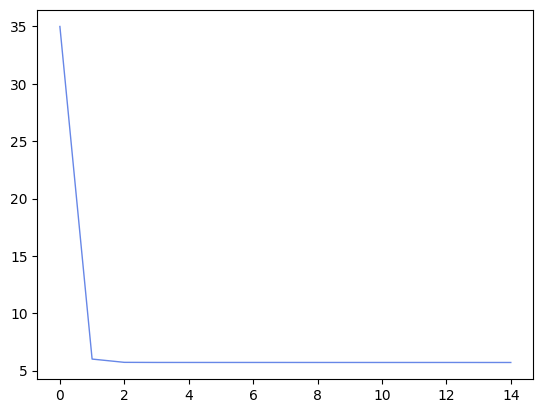

In [69]:
# generate data
X_data, y_data, mislabel = generate_data(dim=20, num=10000) 

# split data
def random_Split_data(X: np.ndarray, y:np.ndarray, rate = 0.7, random_seed: int = -1):
    data: np.ndarray = np.hstack((X, y))
    m, n = data.shape
    if random_seed != -1:
        np.random.seed(abs(random_seed))
    np.random.shuffle(data)
    
    row_split = int(m * rate)
    X_train = data[0: row_split, 0: -1]
    y_train = data[0: row_split, -1: ]
    X_test = data[row_split: m, 0: -1]
    y_test = data[row_split: m, -1: ]
    
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, rate=0.7)


# constrcut model and train (remember record time)
model1 = SVM1() 
loss_list, times = model1.fit(X_train, y_train, gamma = 0.005, lr = 0.002, tol=1e-4, max_times=100)
# loss_list, times = model1.fit(X_train, y_train, tol=1e-2)
# print(model1.w)

# print(times)
# print(loss_list)

# model2 = SVM2(X_train, y_train)
# loss_list, times = model2.fit(gamma = 0.08, tol = 1e-5, max_times=800, epslion=0.05)

# print(model2.alpha)
# print(loss_list)
# print(times)
# print(len(loss_list))


# print(X_train.shape)
# print(y_train.shape)
# m = SVM2(X_train, y_train)
# print(m.err)


import matplotlib.pyplot as plt
def show(times, loss, color = '#4169E1', start=0, end=2000):
    x_axis_data = list(range(times + 1))[start:end]
    y_axis_data = loss[start:end]
    plt.plot(x_axis_data, y_axis_data, color=color, alpha=0.8, linewidth=1)


show(times, loss_list)


# predict and compare your results

In [70]:
# make prediction

def model_cmp(y_pre:np.ndarray, y_test:np.ndarray):
    # y should be in shape m x 1
    corr = 0
    sum = 0
    m, n = y_pre.shape
    
    for i in range(m):
        if y_pre[i] == y_test[i]:
            corr += 1
        sum += 1
    return corr/sum

# pred = model1.predict()

# compared with answer

# compare each methods
# print(X_test.shape)
pre = model1.predict(X_test)
print(pre.shape)
print(model_cmp(pre, y_test))
print(mislabel)


(3000, 1)
0.9513333333333334
0.0362


In [71]:
# Calculate the model accuracy on average

from sklearn import svm

def model_accuracy_ave(model:str = '1', dim = 20, num = 10000, devide_rate = 0.7, total_time = 50):   # all possible parameters

    model_list = ['1', '2', 'skl']
    assert model in model_list, "unknown model: {}".format(model)

    sum = 0
    mis_sum = 0
    cnt = 0

    if model == '1':
        for _ in range(total_time):
            X_data, y_data, mislabel = generate_data(dim, num) 
            X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, devide_rate)

            model = SVM1() 
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            sum = sum + model_cmp(pred, y_test)
            mis_sum = mis_sum + mislabel
            cnt += 1
            # print(model_cmp(pred, y_test))

    elif model == '2':
        i = 0
        while i < total_time:
            X_data, y_data, mislabel = generate_data(dim, num) 
            X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, devide_rate)

            model = SVM2(X_train, y_train) 
            loss, times = model.fit(gamma = 0.1, tol = 1e-3, max_times=800, epslion=0.2)

            if times < 100:
                continue

            pred = model.predict(X_test)
            temp = model_cmp(pred, y_test)

               
            sum += temp
            mis_sum = mis_sum + mislabel
            cnt += 1
            print(temp)
            i += 1

    elif model == 'skl':
        for _ in range(total_time):
            X_data, y_data, mislabel = generate_data(dim, num) 
            X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, devide_rate)

            model = svm.SVC(kernel='linear')
            model.fit(X_train, y_train)
            pred = model.predict(X_test).reshape(-1, 1)

            sum += model_cmp(pred, y_test)
            mis_sum = mis_sum + mislabel
            cnt += 1
            # print(model_cmp(pred, y_test))


    # print(cnt)
    return sum/cnt, mis_sum/cnt
# print("Model_{}:Ave={}".format('2', model_accuracy_ave(dim=5, num=100, model='2', total_time=50)))
# acc, mis = model_accuracy_ave(model='2', total_time=50, dim=10, num=200)
# print("Model_{}:Ave={}, Mis_Ave={}".format('2', acc, mis))


In [72]:
import time
def model_accuracy_cmp(dim = 20, num = 10000, devide_rate = 0.7, total_time = 50):   # all possible parameters

   

    sum = [0, 0, 0]
    timer = [0, 0, 0]
    mis_sum = 0
    i = 0

    while i < total_time:
        X_data, y_data, mislabel = generate_data(dim, num) 
        X_train, y_train, X_test, y_test = random_Split_data(X_data, y_data, devide_rate)

        
        start = time.process_time()
        model1 = SVM2(X_train, y_train) 
        loss, times = model1.fit(gamma = 0.08, tol = 1e-5, max_times=800, epslion=0.05)
        if times < 100:
            continue
        pred1 = model1.predict(X_test)
        sum[1] = sum[1] + model_cmp(pred1, y_test)
        end = time.process_time()
        timer[1] = timer[1] + end - start


        start = time.process_time()
        model0 = SVM1() 
        model0.fit(X_train, y_train)
        pred0 = model0.predict(X_test)
        sum[0] = sum[0] + model_cmp(pred0, y_test)
        end = time.process_time()
        timer[0] = timer[0] + end - start


        start = time.process_time()
        model2 = svm.SVC(kernel='linear')
        model2.fit(X_train, y_train)
        pred2 = model2.predict(X_test).reshape(-1, 1)
        sum[2] = sum[2] + model_cmp(pred2, y_test) 
        end = time.process_time()
        timer[2] = timer[2] + end - start

        mis_sum = mis_sum + mislabel
        i += 1
        # print(sum)
        # print(timer)
        


    return i, sum, mis_sum, timer

# cnt, sum, missum, times = model_accuracy_cmp(dim=10, num=100, total_time=50)
# print("Total times: {}\n    Model_1 accrucy = {}, Model_2 accrucy = {}, Model_skl accurcy = {}\n    mislabel = {}".format(cnt, sum[0]/cnt, sum[1]/cnt, sum[2]/cnt, missum/cnt))
# print("Time cost: model1 = {}, model2 = {}, modelskl={}".format(times[0]/cnt, times[1]/cnt, times[2]/cnt))